In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
#Read Data
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label



In [2]:
#Model Architecture
class EEGNET(torch.nn.Module):
    def __init__(self, activation_func):
        super().__init__()
        self.firstconv = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            torch.nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(2, 1), groups=16, bias=False),
            torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation_funcion(activation_func),
            torch.nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            torch.nn.Dropout(p=0.25)
        )
        self.separableConv = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, (1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation_funcion(activation_func),
            torch.nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            torch.nn.Dropout(p=0.25)
        )
        self.classify = torch.nn.Sequential(
            torch.nn.Linear(in_features=736, out_features=2, bias=True)
        )
        
    def forward(self,input):
        input1 = self.firstconv(input)
        input2 = self.depthwiseConv(input1)
        input3 = self.separableConv(input2)
        input4 = torch.reshape(input3,(-1, 736))
        output = self.classify(input4)
        return output
    
class DeepConvNet(torch.nn.Module):
    def __init__(self, activation_func):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(1, 25, kernel_size=(1, 5)),
            torch.nn.Conv2d(25, 25, kernel_size= (2, 1)),
            torch.nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            activation_funcion(activation_func),
            torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5),
            torch.nn.Conv2d(25, 50, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            activation_funcion(activation_func),
            torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5),
            torch.nn.Conv2d(50, 100, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            activation_funcion(activation_func),
            torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5),
            torch.nn.Conv2d(100, 200, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            activation_funcion(activation_func),
            torch.nn.MaxPool2d(kernel_size=(1,2)),
            torch.nn.Dropout(p=0.5),
        )
        self.classify = torch.nn.Sequential(
            torch.nn.Linear(in_features=8600, out_features=2)
        )
    def forward(self,input):
        input1 = self.network(input)
        input2 = torch.flatten(input1,start_dim=1)
        output = self.classify(input2)
        return output

def activation_funcion(activation_func):
    if activation_func == "ELU":
        return torch.nn.ELU()
    elif activation_func == "RELU":
        return torch.nn.ReLU()
    else:
        return torch.nn.LeakyReLU()

In [3]:
#Train
def train(model,train_loader,optimizer):
    model.train()
    total_num = len(train_loader.dataset)
    true_num = 0
    loss_fn = torch.nn.CrossEntropyLoss()
    for batch_idx, (data, label) in enumerate(train_loader):
        #training
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output,label)
        loss.backward()
        optimizer.step()
        #calculate true output
        prediction = torch.argmax(output,dim=1)
        true_num += torch.count_nonzero(torch.where(label==prediction, 1, 0)).item()
    #return acc
    return 100*true_num/total_num

#Test
def test(model,test_loader):
    model.eval()
    total_num = len(test_loader.dataset)
    true_num = 0
    with torch.no_grad():
        for data, label in test_loader:
            output = model(data)
            prediction = torch.argmax(output,dim=1)
            true_num += torch.count_nonzero(torch.where(label==prediction, 1, 0)).item()
    return 100*true_num/total_num

In [4]:
#Statistic
def draw_acc_graph(acc_list, name_list, color, title, epoch_num):
    epoch = range(epoch_num)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    for acc_list_idx , name_list_idx ,color_idx in zip(acc_list, name_list, color):
        plt.plot(epoch, acc_list_idx, color_idx, label=name_list_idx)
    plt.legend()
    plt.show()
    
def print_highest_acc(acc_list, name_list):
    print("highest_acc:")
    for acc_list_idx , name_list_idx in zip(acc_list, name_list):
        print(name_list_idx,": ",max(acc_list_idx),"%")

In [5]:
def init_train_and_test(network,activation_func,train_loader,test_loader,epoch,batch_size,learning_rate,wd,device):
    if(network=="EEGNET"):
        model = EEGNET(activation_func).to(device)
    else:
        model = DeepConvNet(activation_func).to(device)  
    optimizer = optim.Adam(model.parameters(),lr = learning_rate,weight_decay = wd)
    train_acc_list = []
    test_acc_list = []
    highest_test_acc=0
    for epoch_i in range(epoch):
        train_acc = train(model,train_loader,optimizer)
        test_acc = test(model,test_loader)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        #print("epoch: ",epoch_i," train acc: ",train_acc," test acc: ",test_acc)
        
        if test_acc>highest_test_acc:
            highest_test_acc = test_acc
            if os.path.exists(network+"_"+activation_func+"_model"):
                os.remove(network+"_"+activation_func+"_model")
            torch.save(model.state_dict(), network+"_"+activation_func+"_model")
    return train_acc_list, test_acc_list

In [6]:
def model_main(batch_size):
    #hyperparameter
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    network_list=["EEGNET","DeepConvNet"]
    activation_func_list=["ELU","RELU","LeakyRELU"]
    
    #Load Data
    np_train_data, np_train_label, np_test_data, np_test_label = read_bci_data()
    train_data = torch.tensor(np_train_data, device=device, dtype=torch.float)
    train_label = torch.tensor(np_train_label, device=device, dtype=torch.long)
    test_data = torch.tensor(np_test_data, device=device, dtype=torch.float)
    test_label = torch.tensor(np_test_label, device=device, dtype=torch.long)
    train_loader = DataLoader(TensorDataset(train_data,train_label),batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(test_data,test_label),batch_size=batch_size)
    
    print("acc:")
    for network in network_list:
        for activation_func in activation_func_list:
            if(network=="EEGNET"):
                model = EEGNET(activation_func).to(device)
            else:
                model = DeepConvNet(activation_func).to(device)
            model.load_state_dict(torch.load(network+"_"+activation_func+"_model"))
            model.eval()
            test_acc = test(model,test_loader)
            print(network+"_"+activation_func+"_test: ",test_acc,"%")
                

In [7]:
def no_model_main(batch_size):
    #hyperparameter
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epoch = 2000
    learning_rate = 1e-3
    wd = 0.01
    draw_color_list=['b','g','r','c','m','y']
    network_list=["EEGNET","DeepConvNet"]
    activation_func_list=["ELU","RELU","LeakyRELU"]
    
    #Load Data
    np_train_data, np_train_label, np_test_data, np_test_label = read_bci_data()
    train_data = torch.tensor(np_train_data, device=device, dtype=torch.float)
    train_label = torch.tensor(np_train_label, device=device, dtype=torch.long)
    test_data = torch.tensor(np_test_data, device=device, dtype=torch.float)
    test_label = torch.tensor(np_test_label, device=device, dtype=torch.long)
    train_loader = DataLoader(TensorDataset(train_data,train_label),batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(test_data,test_label),batch_size=batch_size)
    
    highest_acc_list=[]
    highest_name_list=[]
    
    for network in network_list:
        draw_acc_list=[]
        draw_name_list=[]
        draw_title="Activation function comparision("+network+")"
        
        for activation_func in activation_func_list:
            train_acc_list, test_acc_list = init_train_and_test(network,activation_func,train_loader,test_loader,epoch,batch_size,learning_rate,wd,device)
            draw_acc_list.append(train_acc_list)
            draw_acc_list.append(test_acc_list)
            draw_name_list.append(activation_func+"_train")
            draw_name_list.append(activation_func+"_test")
            highest_acc_list.append(test_acc_list)
            highest_name_list.append(network+"_"+activation_func+"_test")
        
        draw_acc_graph(draw_acc_list, draw_name_list, draw_color_list, draw_title, epoch)
        
    print_highest_acc(highest_acc_list, highest_name_list)

In [8]:
def main():
    models_is_exist = 1
    model_name_list = ["EEGNET_ELU_model","EEGNET_RELU_model","EEGNET_LeakyRELU_model","DeepConvNet_ELU_model","DeepConvNet_RELU_model","DeepConvNet_LeakyRELU_model"]
    for model_name in model_name_list:
        if os.path.exists(model_name) == 0:
            models_is_exist = 0
            break
    batch_size=400
    if models_is_exist:
        model_main(batch_size)
    else:
        no_model_main(batch_size)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


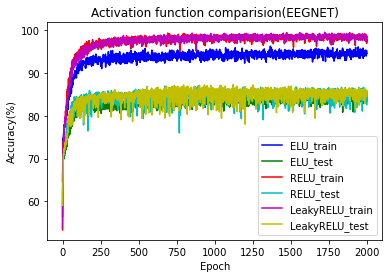

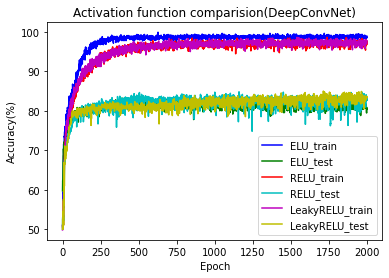

highest_acc:
EEGNET_ELU_test :  85.83333333333333 %
EEGNET_RELU_test :  87.03703703703704 %
EEGNET_LeakyRELU_test :  87.31481481481481 %
DeepConvNet_ELU_test :  83.61111111111111 %
DeepConvNet_RELU_test :  84.81481481481481 %
DeepConvNet_LeakyRELU_test :  85.0 %


In [10]:
#Execution
if __name__ == '__main__':
    main()